In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/processed/OneRepMaxData_250324.csv')

In [3]:
# data.loc[data["PercentageMaxLoad"] > 95, "FileId"].unique()

In [3]:
def add_padding(data, no_frames):
    data = data.reset_index(drop=True)

    first_record, last_record = data.iloc[0], data.iloc[-1]

    to_beginning = pd.concat(no_frames * [pd.DataFrame([first_record])])
    to_end = pd.concat(no_frames * [pd.DataFrame([last_record])])

    data = pd.concat([to_beginning, data, to_end], ignore_index=True)

    return data

In [4]:
def inverse_y_axis(data):

    data_copy = data.copy()
    max_value = data_copy["PelvisY"].max()

    data_copy.loc[:, "PelvisY"] = max_value - data_copy["PelvisY"]

    return data_copy

In [5]:
def fetch_value(data, index):

    return float(data.loc[index, "PelvisY"])

In [6]:
def find_initialPosition(data, stability_threshold):
    
    data_copy = data.copy()
    data_copy["Variability"] = data_copy["PelvisY"].diff()
    
    initialPosition_index = int(
        data_copy.loc[data_copy["Variability"].abs() >= stability_threshold].index[0] - 1)

    initialPosition_value = fetch_value(data, initialPosition_index)
    
    initialPosition = (
        initialPosition_index,
        initialPosition_value
    )
    
    return initialPosition

In [7]:
def find_bottomPosition(data):

    bottomPosition_index = data["PelvisY"].idxmin()
    bottomPosition_value = fetch_value(data, bottomPosition_index)

    bottomPosition = (
        bottomPosition_index,
        bottomPosition_value
    )

    return bottomPosition

In [8]:
def MaxValueBased_method(data, bottomPosition):

    uprightPosition_index = data.loc[bottomPosition[0]:, "PelvisY"].idxmax()

    uprightPosition_value = fetch_value(data, uprightPosition_index)

    uprightPosition = (
        uprightPosition_index,
        uprightPosition_value
    )

    return uprightPosition

In [9]:
def StabilityBased_method(data, stability_threshold):

    reversed_data = data[::-1].copy()
    reversed_data["Variability"] = reversed_data["PelvisY"].diff()  
    
    uprightPosition_index = int(
        reversed_data.loc[reversed_data["Variability"] <= -stability_threshold].index[0] - 1)

    uprightPosition_value = fetch_value(data, uprightPosition_index)
    
    uprightPosition = (
        uprightPosition_index,
        uprightPosition_value
    )
    
    return uprightPosition

In [11]:
def find_uprightPosition(data, bottomPosition, stability_threshold, alpha):

    maxValue_index = MaxValueBased_method(
        data, bottomPosition)[0]

    stability_index = StabilityBased_method(
        data, stability_threshold)[0]

    uprightPosition_index = int(
        (1 - alpha) * maxValue_index + alpha * stability_index)
    
    uprightPosition_value = fetch_value(data, uprightPosition_index)

    uprightPosition = (
        uprightPosition_index,
        uprightPosition_value
    )

    return uprightPosition

In [12]:
def find_keyPositions(data, stability_threshold, alpha):

    initialPosition = find_initialPosition(
        data, stability_threshold)
    
    bottomPosition = find_bottomPosition(data)

    uprightPosition = find_uprightPosition(
        data, bottomPosition, stability_threshold, alpha)

    return initialPosition, bottomPosition, uprightPosition

In [13]:
def calculate_DescentVelocity(initialPosition, bottomPosition):

    velocity = abs(
        (bottomPosition[1] - initialPosition[1]) / (bottomPosition[0] - initialPosition[0]))
    
    return velocity


def calculate_AscentVelocity(bottomPosition, uprightPosition):
    
    velocity = abs(
        (uprightPosition[1] - bottomPosition[1]) / (uprightPosition[0] - bottomPosition[0]))
    
    return velocity

006_01_08_06_025_1_R
0.031900066565375126 0.04120315661810847


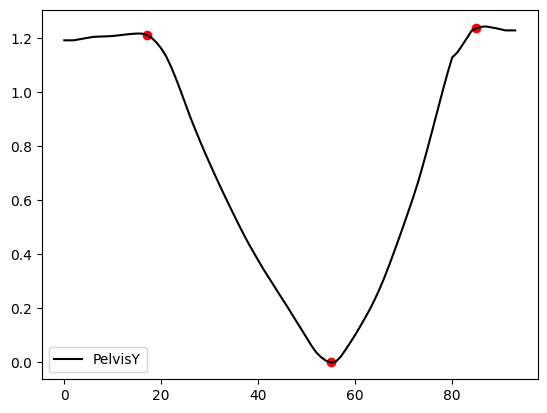

In [14]:
random_Id = data.sample()["FileId"].iloc[0]

random_data = data.loc[data["FileId"] == random_Id, ["PelvisY"]]

random_data = add_padding(random_data, 2)
random_data = inverse_y_axis(random_data)

print(random_Id)
random_data.plot(color="black")

i, b, u = find_keyPositions(random_data, stability_threshold=0.01, alpha=0.25)
plt.scatter(x = (i[0], b[0], u[0]), y = (i[1], b[1], u[1]), c="r");

descentVel = calculate_DescentVelocity(i, b)
ascentVel = calculate_AscentVelocity(b, u)
print(descentVel, ascentVel)

In [45]:
tmp = {
    "pml" : [],
    "descVal": [],
    "ascVal": []
}

for _, file_data in data.groupby(by='FileId'):

    pml = file_data[["PercentageMaxLoad"]].iloc[0].values[0]

    file_data = file_data[["PelvisY"]]
    file_data = inverse_y_axis(file_data)

    i, b, u = find_keyPositions(
        file_data,
        stability_threshold=0.01,
        alpha=0.25)

    descVal = calculate_DescentVelocity(i, b)
    ascVal = calculate_AscentVelocity(b, u)

    tmp["pml"].append(pml)
    tmp["descVal"].append(descVal)
    tmp["ascVal"].append(ascVal)

df = pd.DataFrame(tmp)

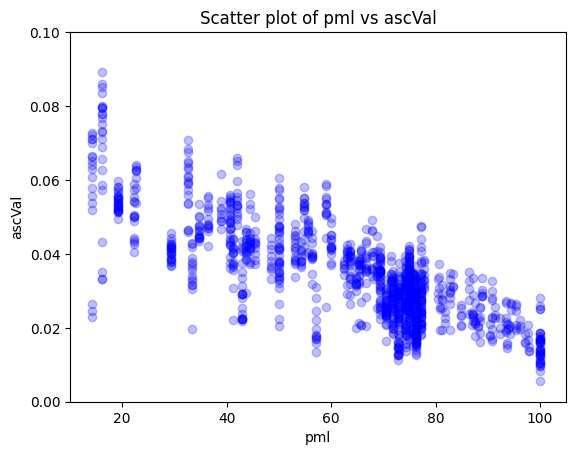

In [55]:
plt.scatter(df['pml'], df['ascVal'], color='blue', alpha=0.25)
plt.xlabel('pml')
plt.xlim((10, 105))
plt.ylabel('ascVal')
plt.ylim((0, 0.1))
plt.title('Scatter plot of pml vs ascVal')

plt.show()

In [56]:
df = data.loc[(data["Repetitions"] == 1) & (data["RepNumber"] == 1)]

tmp = {
    "pml" : [],
    "descVal": [],
    "ascVal": []
}

for _, file_data in df.groupby(by='FileId'):

    pml = file_data[["PercentageMaxLoad"]].iloc[0].values[0]

    file_data = file_data[["PelvisY"]]
    file_data = inverse_y_axis(file_data)

    i, b, u = find_keyPositions(
        file_data,
        stability_threshold=0.01,
        alpha=0.25)

    descVal = calculate_DescentVelocity(i, b)
    ascVal = calculate_AscentVelocity(b, u)

    tmp["pml"].append(pml)
    tmp["descVal"].append(descVal)
    tmp["ascVal"].append(ascVal)

df = pd.DataFrame(tmp)

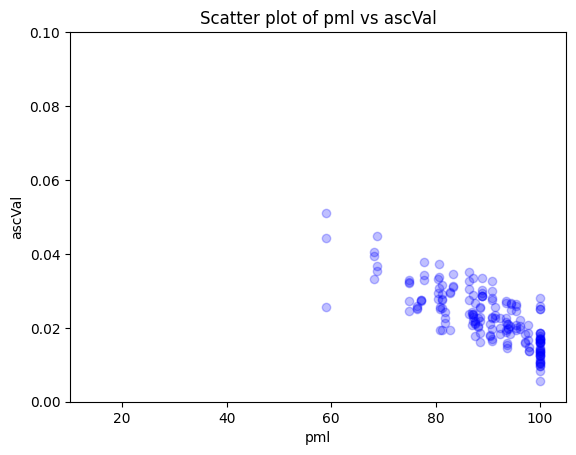

In [57]:
plt.scatter(df['pml'], df['ascVal'], color='blue', alpha=0.25)
plt.xlabel('pml')
plt.xlim((10, 105))
plt.ylabel('ascVal')
plt.ylim((0, 0.1))
plt.title('Scatter plot of pml vs ascVal')

plt.show()

006_12_12_11_060_1_C
0.0302150308670414 0.024785586309416487


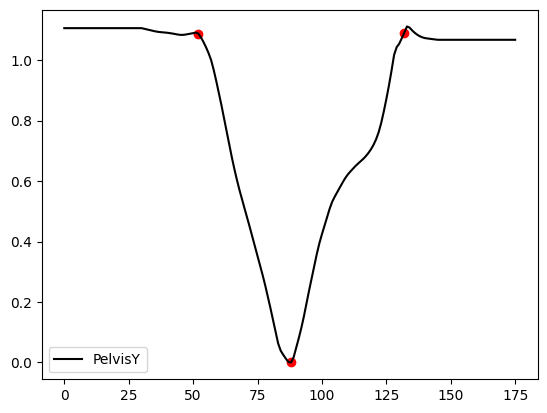

In [106]:
random_Id = data.sample()["FileId"].iloc[0]

random_data = data.loc[data["FileId"] == random_Id, ["PelvisY"]]

random_data = add_padding(random_data, 30)
random_data = inverse_y_axis(random_data)

print(random_Id)
random_data.plot(color="black")

i, b, u = find_keyPositions(random_data, stability_threshold=0.01, alpha=0.25)
plt.scatter(x = (i[0], b[0], u[0]), y = (i[1], b[1], u[1]), c="r");

descentVel = calculate_DescentVelocity(i, b)
ascentVel = calculate_AscentVelocity(b, u)
print(descentVel, ascentVel)

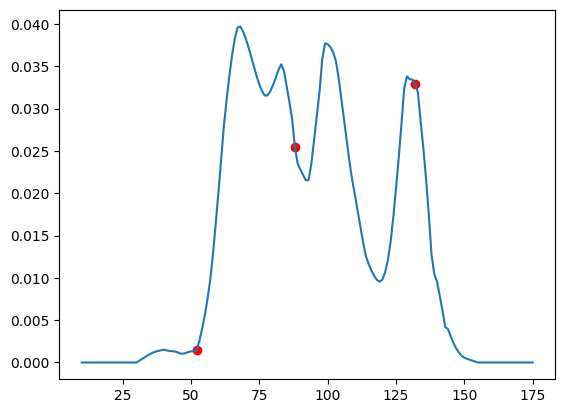

In [109]:
random_data["Velocity"] = random_data["PelvisY"].diff().abs().rolling(window=10).mean()

random_data["Velocity"].plot()
plt.scatter(
    x = (i[0], b[0], u[0]),
    y = (
        random_data.loc[i[0], "Velocity"],
        random_data.loc[b[0], "Velocity"],
        random_data.loc[u[0], "Velocity"],
        ),
    c="r");

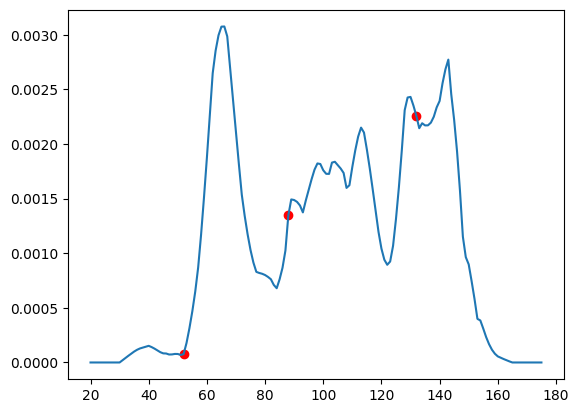

In [111]:
random_data["Acceleration"] = random_data["Velocity"].diff().abs().rolling(window=10).mean()

random_data["Acceleration"].plot()
plt.scatter(
    x = (i[0], b[0], u[0]),
    y = (
        random_data.loc[i[0], "Acceleration"],
        random_data.loc[b[0], "Acceleration"],
        random_data.loc[u[0], "Acceleration"],
        ),
    c="r");